# Air Traffic Model Prototyping

This notebook defines a prototype air traffic model.

This model makes the following assumptions:
- A crew is available when each aircraft wants to depart (i.e. crew factors do not affect schedule),
- Each airport has one runway shared by arrivals and departures, and no limit to the number of aircraft who can be waiting to use it, so they are modeled as M/M/1/inf/FIFO queues

In [6]:
# Import and setup
import logging
import pprint

import pandas as pd
import matplotlib.pyplot as plt

import pyro

from bayes_air.model import air_traffic_network_model
from bayes_air.state import State, parse_schedule

pyro.enable_validation(True)
pyro.set_rng_seed(1)
logging.basicConfig(level=logging.DEBUG)

# Set matplotlib settings
%matplotlib inline
plt.style.use('default')

DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.


DEBUG:graphviz.backend.execute:run [PosixPath('dot'), '-Kdot', '-Tsvg']


Sampling service time 0.151164710521698 with rate 6.532366752624512
Sampling service time 0.024991368874907494 with rate 5.522851943969727
Sampling service time 0.17981043457984924 with rate 5.522851943969727
Sampling service time 0.11915569752454758 with rate 6.532366752624512


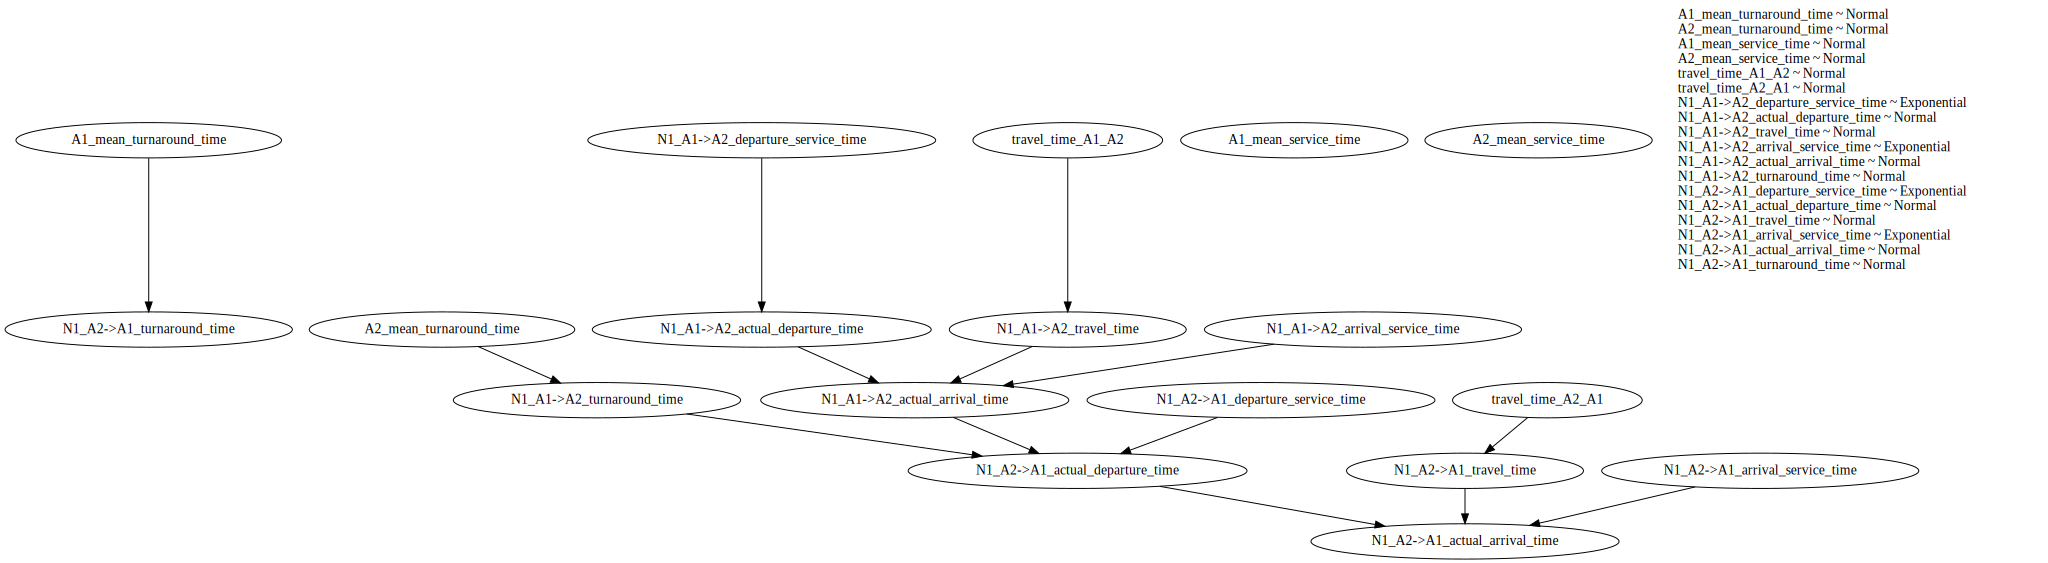

In [5]:
# Define a simple schedule that sends the aircraft from airport 0 to airport 1 and back
# Time is defined in hours from the start of the simulation
schedule = pd.DataFrame(
    {
        "tail_number": ["N1", "N1"],
        "origin_airport": ["A1", "A2"],
        "destination_airport": ["A2", "A1"],
        "scheduled_departure_time": [0.0, 1.5],
        "scheduled_arrival_time": [1.0, 3.0],
        "actual_departure_time": [None, None],
        "actual_arrival_time": [None, None],
    }
)

state = parse_schedule(schedule)
pyro.render_model(
    air_traffic_network_model,
    model_args=(state, 5.0, 0.1),
    render_params=True,
    render_distributions=True,
)

In [7]:
simulated_state = air_traffic_network_model(state, 5.0, 0.1)
pprint.pprint(simulated_state)

Sampling service time 0.151164710521698 with rate 6.532366752624512
Sampling service time 0.024991368874907494 with rate 5.522851943969727
Sampling service time 0.17981043457984924 with rate 5.522851943969727
Sampling service time 0.11915569752454758 with rate 6.532366752624512
State(in_flight_aircraft=[],
      airports={'A1': Airport(code='A1',
                              runway_queue=[],
                              parked_aircraft=[(Aircraft(tail_number='N1',
                                                         itinerary=[ItineraryItem(origin='A1',
                                                                                  destination='A2',
                                                                                  scheduled_departure_time=0.0,
                                                                                  scheduled_arrival_time=1.0,
                                                                                  actual_departure_time=tensor(0

/home/cbd/src/mit/bayes_air/bayes_air/model.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(1.0 / airport_service_times[airport.code])
